__This notebook shows a frequency analysis of the bee's brain activity. Since no further periodicy between different flight rounds (or parts of rounds) could be discovered than in previous notebooks, results of this notebook are not presented in the thesis.__

In [ ]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal

import bee_view_analyzer.Correlation as Correlation
import bee_view_analyzer.DataLoader as DataLoader
import bee_view_analyzer.Utils as Utils
import bee_view_analyzer.Visualizer as Visualizer

In [ ]:
spike_rates = []

csv_file_path = Utils.get_path(["flights", "flight_2018_09_03#1"],
                               "030918_01_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
spike_rates.append(DataLoader.load_neuro_data(None, csv_file_path, spike_type_row = 8, start_frame = 600))

csv_file_path = Utils.get_path(["flights", "flight_2018_09_03#2"],
                               "030918_2_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
spike_rates.append(DataLoader.load_neuro_data(None, csv_file_path, spike_type_row = 2, start_frame = 600))

csv_file_path = Utils.get_path(["flights", "flight_2018_09_03#3"],
                               "030918_3_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
spike_rates.append(DataLoader.load_neuro_data(None, csv_file_path, spike_type_row = 2, start_frame = 600))

csv_file_path = Utils.get_path(["flights", "flight_2018_09_03#4"],
                               "030918_4_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv")
spike_rates.append(DataLoader.load_neuro_data(None, csv_file_path, spike_type_row = 2, start_frame = 600))


spike_rates_small = []

csv_path = Utils.get_path(["flights", "flight_2018_09_03#1"],
                          "030918_01_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv")
spike_rates_small.append(DataLoader.load_neuro_data(None, csv_path, 8, 6000))

csv_path = Utils.get_path(["flights", "flight_2018_09_03#2"],
                          "030918_2_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv")
spike_rates_small.append(DataLoader.load_neuro_data(None, csv_path, 2, 6000))

camera_positions = []

path = Utils.get_path(["flights", "flight_2018_09_03#1"], "camera_positions.dill")
camera_positions.append(Utils.load_object(path))

path = Utils.get_path(["flights", "flight_2018_09_03#2"], "camera_positions.dill")
camera_positions.append(Utils.load_object(path))

path = Utils.get_path(["flights", "flight_2018_09_03#3"], "camera_positions.dill")
camera_positions.append(Utils.load_object(path))

path = Utils.get_path(["flights", "flight_2018_09_03#4"], "camera_positions.dill")
camera_positions.append(Utils.load_object(path))

start_rounds = [[630, 2900, 4580],
                [743, 2390, 4070, 5770],
                [110, 1950, 3650, 5330],
                [330, 1980, 3650, 5330]]

end_rounds = [[2120, 4370, 6050],
              [2220, 3880, 5555, 7220],
              [1600, 3440, 5150, 6795],
              [1800, 3450, 5120, 6750]]

In [ ]:
def load_raw_voltage(csv_file_path):
    votage_data_left = []
    votage_data_right = []
    long = []
    lat = []
    
    i = 0
    
    with open(csv_file_path) as csvfile:
        neuro_reader = csv.reader(csvfile)
    
        row_num = -1
        for row in neuro_reader:
            row_num += 1
            
            votage_data_left.append(int(row[0]))
            votage_data_right.append(int(row[1]))
            
    return np.array(votage_data_left), np.array(votage_data_right)

csv_path = Utils.get_path(["flights", "flight_2018_09_03#1"], "030918_01_out_adc_synced.csv")
voltage_left, voltage_right = load_raw_voltage(csv_path)

__Functions from notebook '4_spike_rate' section 4:__

In [ ]:
def get_points(camera_positions, flight_num):
    points = []
    
    for i in range(len(camera_positions[flight_num])):
        points.append([camera_positions[flight_num][i][0], camera_positions[flight_num][i][2]])
    
    return points

# mean points fixed every 'distance' meter
def create_mean_parts(distance, points, neuro_data, flight_num):
    dst = np.linalg.norm(np.array(points[ : -1]) - np.array(points[1 : ]), axis = 1)

    ordered_points = []
    mean_points = []

    ordered_neuro = []

    current_distance = 0
    current_mean = None
    current_point_list = [points[0]]
    current_neuro_list = [neuro_data[flight_num][0]]

    half_distance = distance / 2
    p = 0

    for i in range(1, min(len(points), len(neuro_data[flight_num]))):
        dist = dst[i - 1]
        current_distance += dist
        
        if current_mean is None and current_distance > half_distance:                
            current_element = np.array(points[i])
            prev_element = np.array(current_point_list[-1])
            dst_to_prev =  np.linalg.norm(current_element - prev_element)
                
            p = ((current_distance - half_distance) / dst_to_prev)
            current_mean = current_element + (prev_element - current_element) * p

        if current_distance > distance:            
            mean_points.append(current_mean)
            current_mean = None

            ordered_points.append(current_point_list)
            ordered_neuro.append(current_neuro_list)
            
            current_distance -= distance

            current_point_list = [points[i]]
            current_neuro_list = [neuro_data[flight_num][i]]
        else:
            current_point_list.append(points[i])
            current_neuro_list.append(neuro_data[flight_num][i])
                
            
    return ordered_points, mean_points, ordered_neuro
    
def _drop_wrong_rounds(start_frames, end_frames):
    if len(start_frames) > len(end_frames):
        start_frames = start_frames[ : -1]

    round_lengths = np.array(end_frames) - np.array(start_frames)
    median = np.median(round_lengths)

    starts = []
    ends = []
    for i in range(len(round_lengths)):
        if round_lengths[i] > 0.7 * median:
            starts.append(start_frames[i])
            ends.append(end_frames[i])
            
    return starts, ends

def get_round_start_end(camera_positions, flight_num = -1):
    delta_x = 187 # distance to leftmost x-coordinate from origin on field
    delta_y = 297 # distance to topmost y-coordinate from origin on field
    
    starts = []
    ends = []
    
    for flight_number in range(len(camera_positions)):
        if flight_num >= 0 and flight_number != flight_num:
            continue
        
        start_frames = []
        end_frames = []

        round_flying = False

        for i in range(len(camera_positions[flight_number])):
            x = int(delta_x + np.around(camera_positions[flight_number][i][0]))
            y = int(delta_y - np.around(camera_positions[flight_number][i][2]))

            # y > 330 to get last rounds of flights where drone does not always move out of visible map
            if not round_flying and y < 330 and x < 258:
                round_flying = True
                start_frames.append(i)
            elif round_flying and y >= 330 or x >= 258:
                round_flying = False
                end_frames.append(i)
        
        start_frames, end_frames = _drop_wrong_rounds(start_frames, end_frames)
        
        if flight_num >= 0:
            return start_frames, end_frames
        
        starts.append(start_frames)
        ends.append(end_frames)
    
    return starts, ends
            
def get_base_round(round_num, start_frames, end_frames, ordered_points, mean_points, ordered_neuro):
    current_frame_num = 0
    mean_start_index = -1
    mean_end_index = -1
    base_neuro = []
    
    for part_num in range(len(ordered_points)):
        current_frame_num += len(ordered_points[part_num])
        
        if mean_start_index == -1 and current_frame_num >= start_frames[round_num]:
            mean_start_index = part_num
            mean_part_start = start_frames[round_num] - current_frame_num
        elif mean_end_index == -1 and current_frame_num >= end_frames[round_num]:
            mean_end_index = part_num
            mean_part_end = end_frames[round_num] - current_frame_num
            break
    
    round_points = ordered_points[mean_start_index : mean_end_index + 1]
    round_points[0] = round_points[0][mean_part_start : ]
    
    
    round_neuro = ordered_neuro[mean_start_index : mean_end_index + 1]
    round_neuro[0] = round_neuro[0][mean_part_start : ]
    
    if mean_part_end != 0:
        round_points[-1] = round_points[-1][ : mean_part_end]
        round_neuro[-1] = round_neuro[-1][ : mean_part_end]
    
    round_mean_points = mean_points[mean_start_index : mean_end_index + 1]
    #tree = spatial.KDTree(round_mean_points)
    
    return round_points, round_mean_points, round_neuro

def match_round(round_num, start_frames, end_frames, points, base_round_mean, neuro_data):
    round_points = [[] for i in range(len(base_round_mean))]
    round_neuro_data = [[] for i in range(len(base_round_mean))]
    
    current_mean_index = 0
    
    for i in range(start_frames[round_num], end_frames[round_num]):        
        if current_mean_index + 1 < len(base_round_mean):
            current_distance = np.linalg.norm(points[i] - base_round_mean[current_mean_index])
            next_distance = np.linalg.norm(points[i] - base_round_mean[current_mean_index + 1])

            if next_distance < current_distance:
                current_mean_index += 1
            
        round_points[current_mean_index].append(points[i])
        round_neuro_data[current_mean_index].append(neuro_data[i])
        
    return round_points, round_neuro_data

def match_rounds(flight_num, start_frames, end_frames, points, base_round_mean, neuro_data):
    matched_round_points = []
    matched_round_neuro_data = []

    for round_num in range(len(start_frames)):
        matched_round, matched_neuro = match_round(round_num, start_frames, end_frames, points, base_round_mean,
                                                   neuro_data[flight_num])

        matched_round_points.append(matched_round)
        matched_round_neuro_data.append(matched_neuro)
        
    return matched_round_points, matched_round_neuro_data

def _enlarge_series(series, diff):
    if len(series) > 0:
        mean = np.mean(series)
    else:
        mean = 0
    
    middle = len(series) // 2    
    return np.insert(series, middle, [mean] * np.abs(diff))

def equalize_round_lengths(base_neuro, matched_rounds_neuro):
    equalized_base_round_neuro = [base_neuro.copy() for i in range(len(matched_rounds_neuro))]
    
    for round_num in range(len(matched_rounds_neuro)):
        for part_num in range(len(matched_rounds_neuro[round_num])):
            diff = len(equalized_base_round_neuro[round_num][part_num]) - len(matched_rounds_neuro[round_num]
                                                                                                  [part_num])
            
            if diff < 0:
                series = _enlarge_series(equalized_base_round_neuro[round_num][part_num], diff)
                equalized_base_round_neuro[round_num][part_num] = series
            elif diff > 0:
                series = _enlarge_series(matched_rounds_neuro[round_num][part_num], diff) 
                matched_rounds_neuro[round_num][part_num] = series
                
    return equalized_base_round_neuro, matched_rounds_neuro

def correlate_rounds(base_round_neuro, matched_round_neuro_data):
    corrs = []
    
    for round_num in range(len(base_round_neuro)):
        corr_round = []
        
        for part_num in range(len(base_round_neuro[round_num])):
            corr = Correlation.correlate_series(base_round_neuro[round_num][part_num],
                                                matched_round_neuro_data[round_num][part_num])
            corr_round.append(corr)
            
        corrs.append(corr_round)
        
    return corrs

def plot_synced_time_slices(camera_positions, flight_num, base_round_num, distance, smoothness = 1,
                            smooth_points = 100):
    
    points = get_points(camera_positions, flight_num)
    start_frames, end_frames = get_round_start_end(camera_positions, flight_num)
    ordered_points, mean_points, ordered_neuro = create_mean_parts(distance, points, spike_rates, flight_num)
    
    base_round_points, base_round_mean, base_round_neuro = get_base_round(base_round_num, start_frames, end_frames,
                                                                          ordered_points, mean_points,
                                                                          ordered_neuro)
    
    matched_round_points, matched_round_neuro_data = match_rounds(flight_num, start_frames, end_frames, points,
                                                                  base_round_mean, spike_rates)
    
    eq_base_round_neuro, eq_matched_round_neuro = equalize_round_lengths(base_round_neuro,
                                                                         matched_round_neuro_data)
    
    corrs = correlate_rounds(eq_base_round_neuro, eq_matched_round_neuro)
    
    labels = ["Round 1", "Round 2", "Round 3"]
    
    Visualizer.plot(corrs, labels = labels)
    Visualizer.plot(corrs, labels = labels, smoothness = smoothness, smooth_points = smooth_points)
    
def mean_bins(matched_neuro_data):
    means = []
    
    for round_num in range(len(matched_neuro_data)):
        round_means = []
        
        for part_num in range(len(matched_neuro_data[round_num])):          
            part = matched_neuro_data[round_num][part_num]
            
            if part == []:
                round_means.append(0)
            else:
                round_means.append(np.mean(part))
            
        means.append(round_means)
        
    return means

# Compare spike rate behaviour visually between different rounds

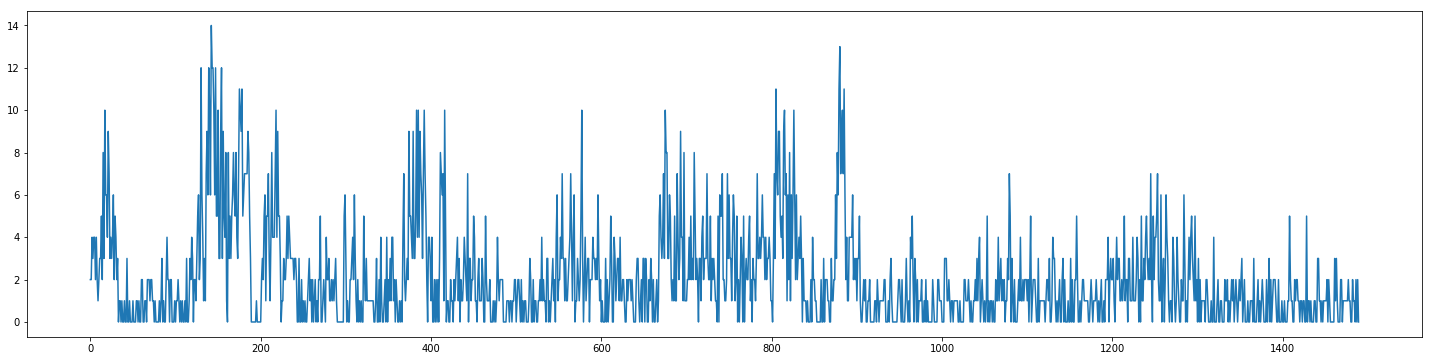

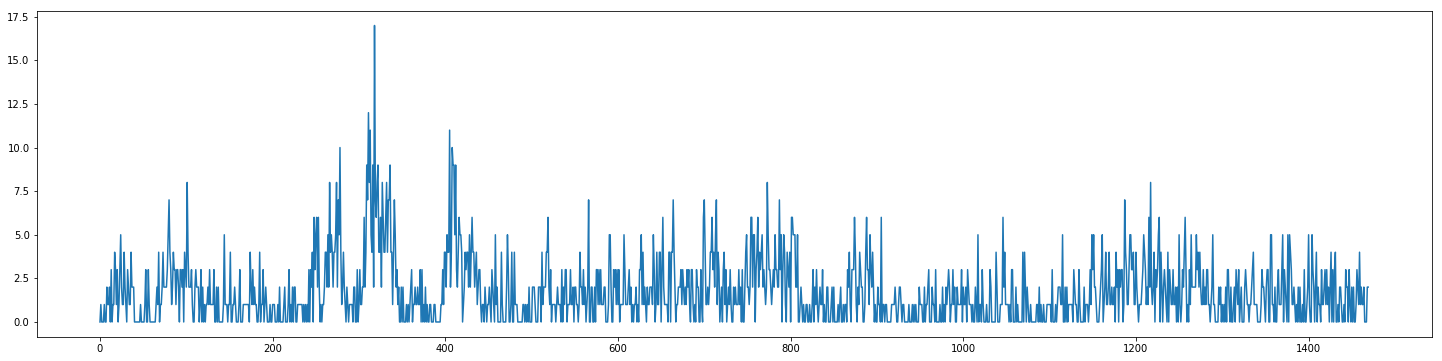

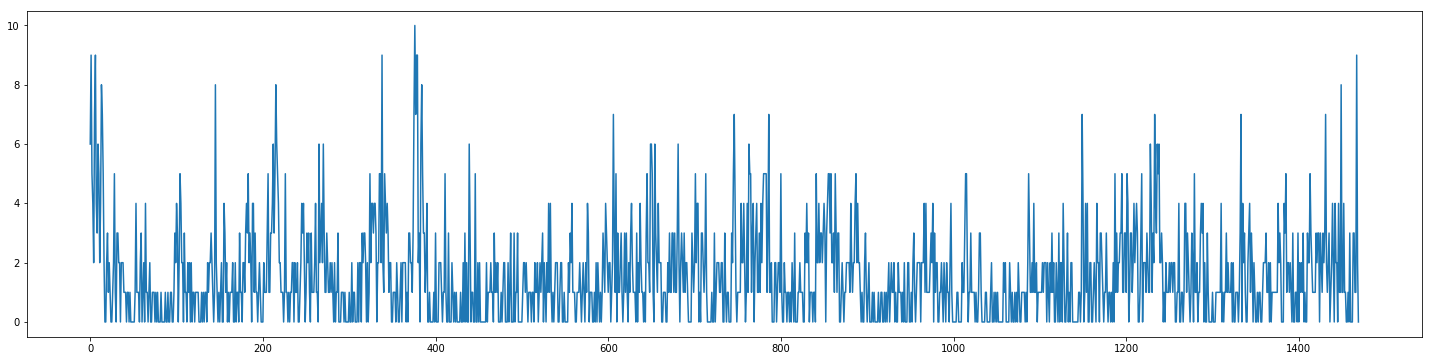

In [ ]:
def plot_round(flight_num, round_num, large_intervall):
    plt.figure(figsize=(25, 6))
    
    if large_intervall:
        plt.plot(spike_rates[flight_num][start_rounds[flight_num][round_num] : end_rounds[flight_num][round_num]])
    else:
        plt.plot(spike_rates_small[flight_num][start_rounds[flight_num][round_num] * 10 : end_rounds[flight_num][round_num] * 10])
    
plot_round(0, 0, True)
plot_round(0, 1, True)
plot_round(0, 2, True)

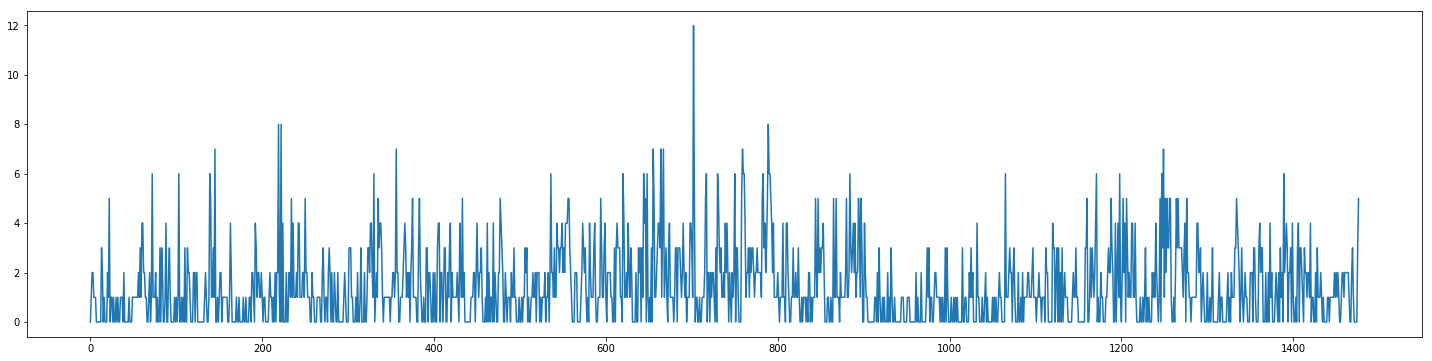

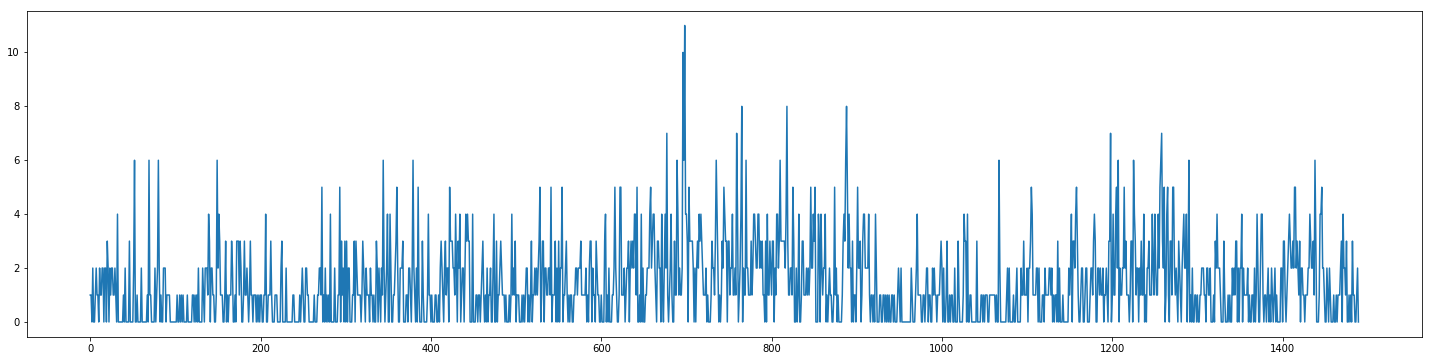

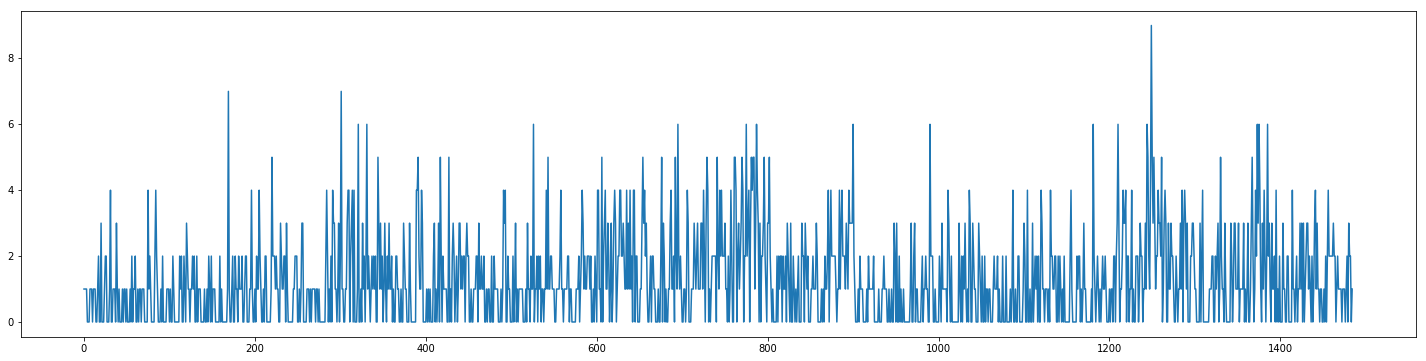

In [ ]:
plot_round(1, 0, True)
plot_round(1, 1, True)
plot_round(1, 2, True)

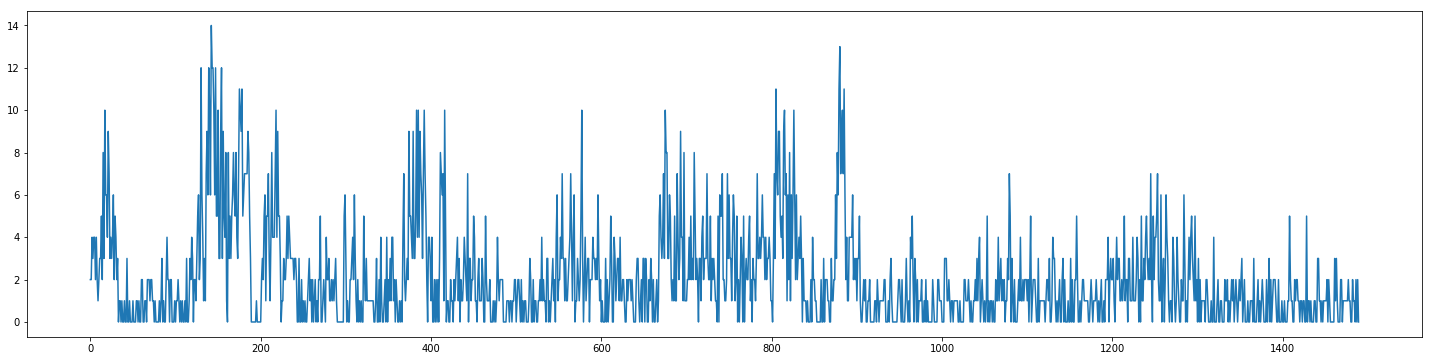

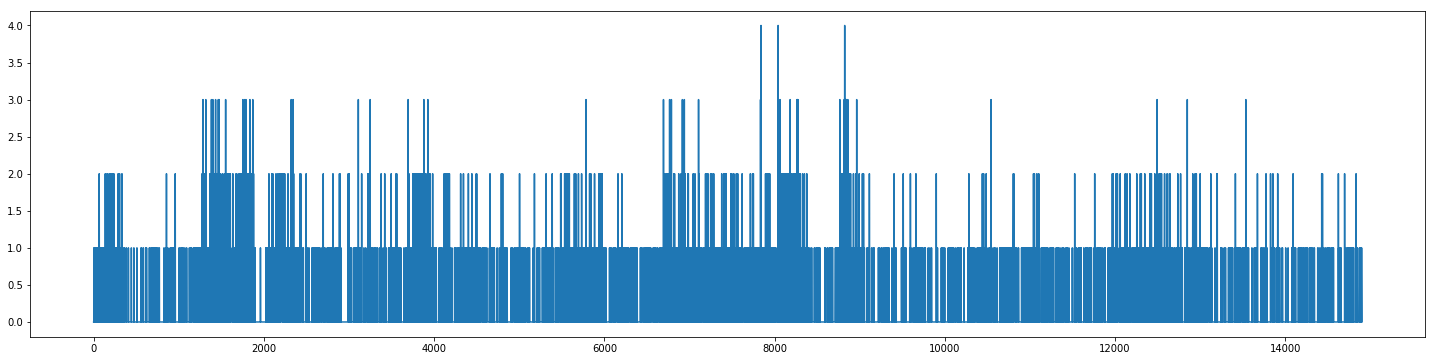

In [ ]:
plot_round(0, 0, True)
plot_round(0, 0, False)

# Spectrogram

In [ ]:
def plot_spectrogram(data, window_size, rate, noverlap = 0, use_log = False):
    freqs, times, Sx = signal.spectrogram(data, fs = rate, nperseg = window_size, noverlap = noverlap)
    
    if use_log:
        Sx = np.log(Sx)

    f, ax = plt.subplots(figsize=(4.8 * 5, 2.4 * 5))
    mesh = ax.pcolormesh(times, freqs, Sx, cmap='viridis')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time [s]')
    plt.colorbar(mesh)

## Spike Rate

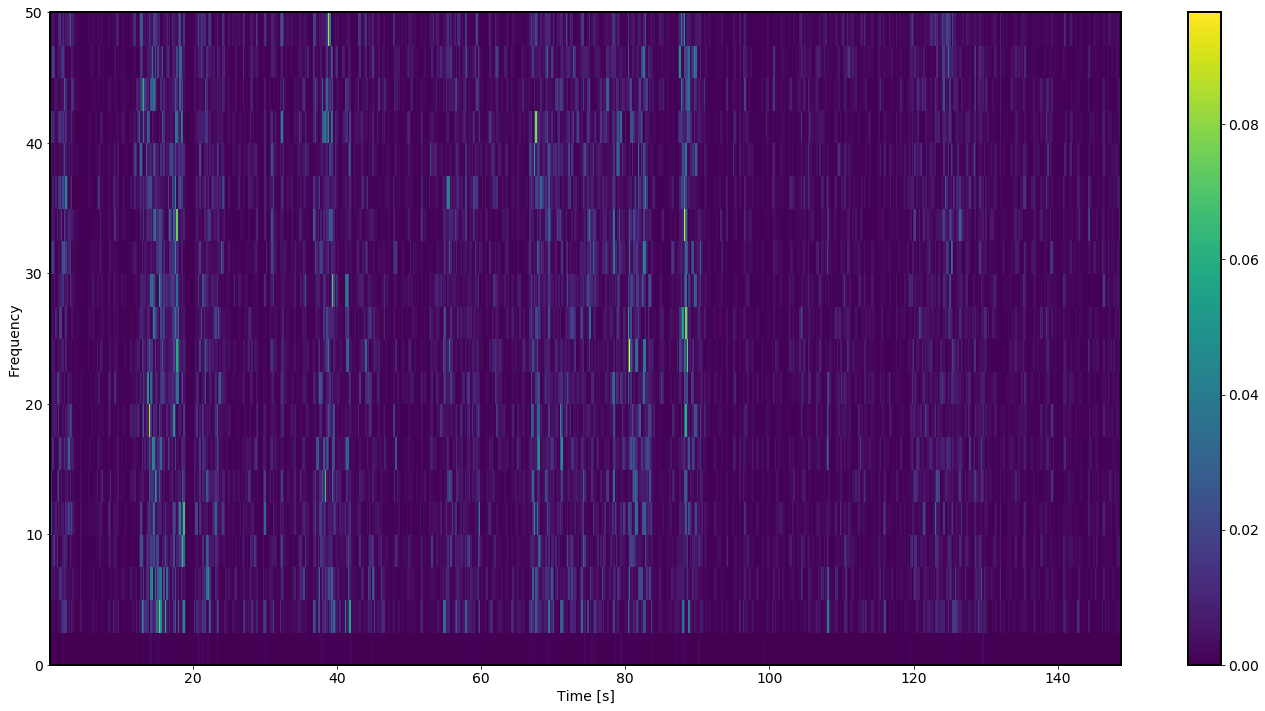

In [ ]:
plot_spectrogram(spike_rates_small[0][start_rounds[0][0] * 10 : end_rounds[0][0] * 10],
                 window_size = 40,
                 rate = 100,
                 noverlap = 20)

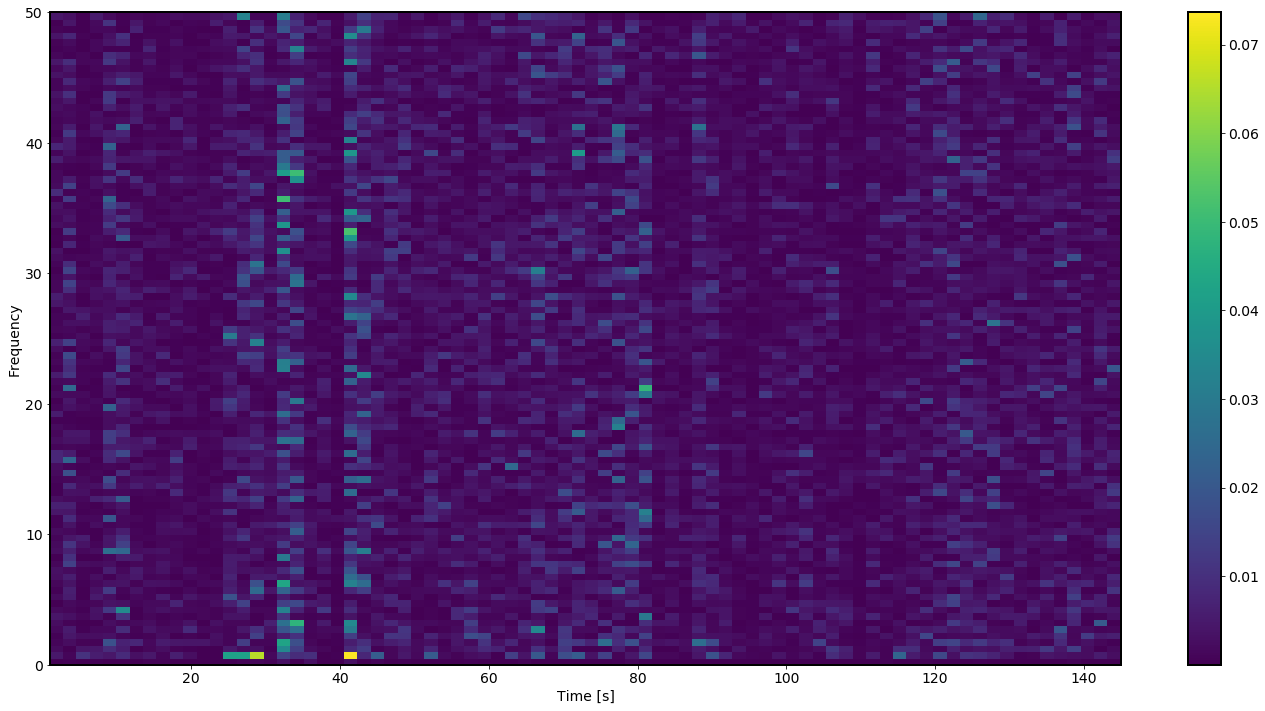

In [ ]:
plot_spectrogram(spike_rates_small[0][start_rounds[0][1] * 10 : end_rounds[0][1] * 10],
                 window_size = 200,
                 rate = 100,
                 noverlap = 20)

### Time slices

In [ ]:
def time_slice_spectrogram(flight_num, distance, base_round_num, spectro_round,
                          spectro_window_size, spectro_noverlap = 0):
    
    points = get_points(camera_positions, flight_num)
    start_frames, end_frames = get_round_start_end(camera_positions, flight_num)
    ordered_points, mean_points, ordered_neuro = create_mean_parts(distance, points, spike_rates, flight_num)
    
    base_round_points, base_round_mean, base_round_neuro = get_base_round(base_round_num, start_frames, end_frames,
                                                                          ordered_points, mean_points,
                                                                          ordered_neuro)
    
    matched_round_points, matched_round_neuro_data = match_rounds(flight_num, start_frames, end_frames, points,
                                                                  base_round_mean, spike_rates)
    
    eq_base_round_neuro, eq_matched_round_neuro = equalize_round_lengths(base_round_neuro,
                                                                         matched_round_neuro_data)
    corrs = correlate_rounds(eq_base_round_neuro, eq_matched_round_neuro)
    
    plot_spectrogram(np.array(corrs[spectro_round]), spectro_window_size, 10, spectro_noverlap)

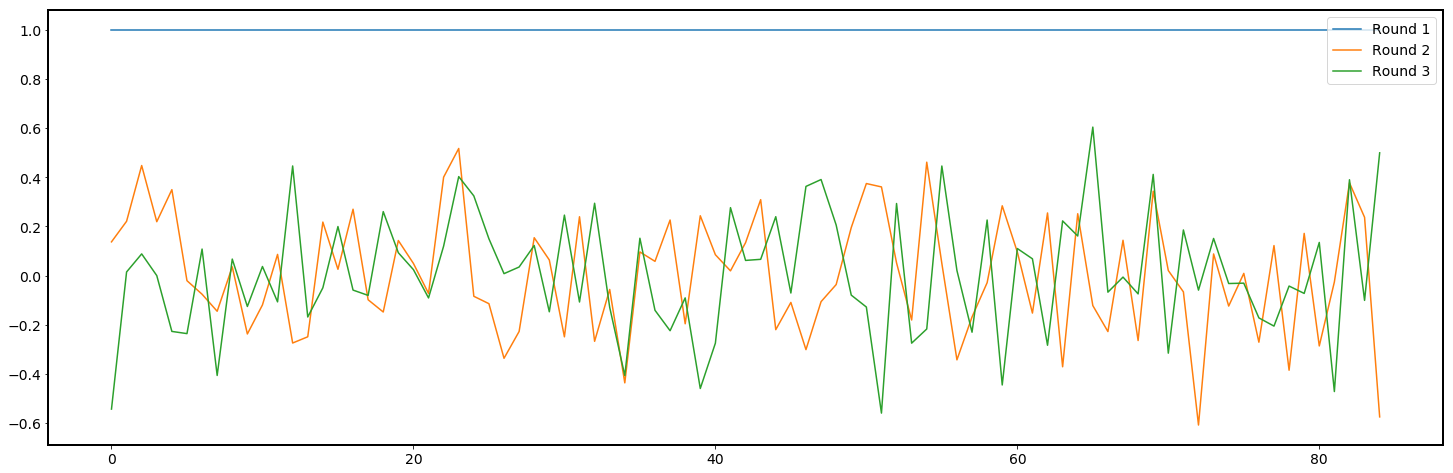

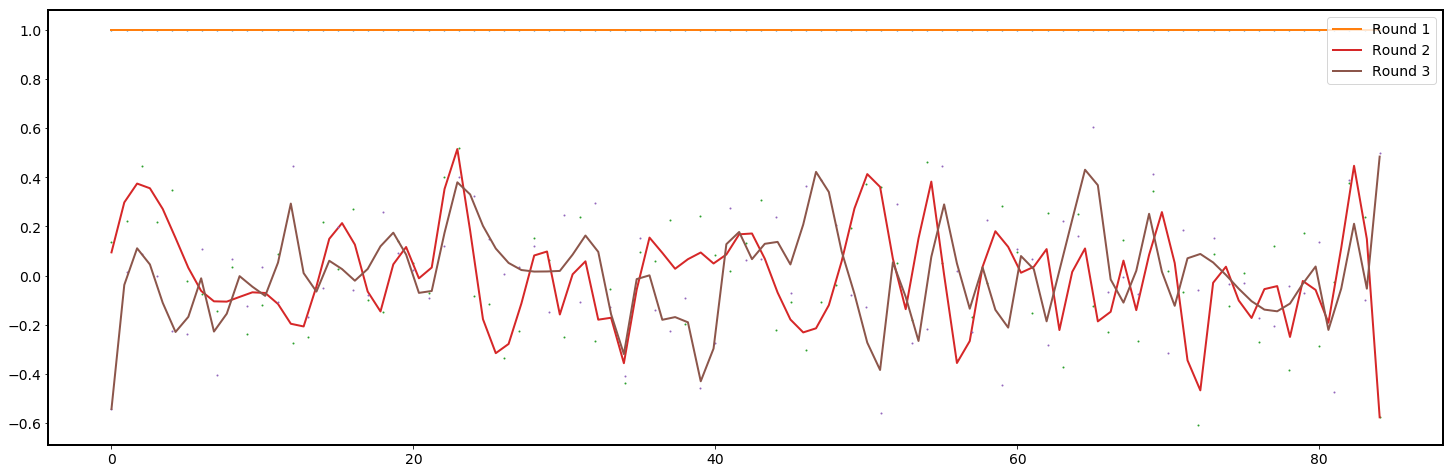

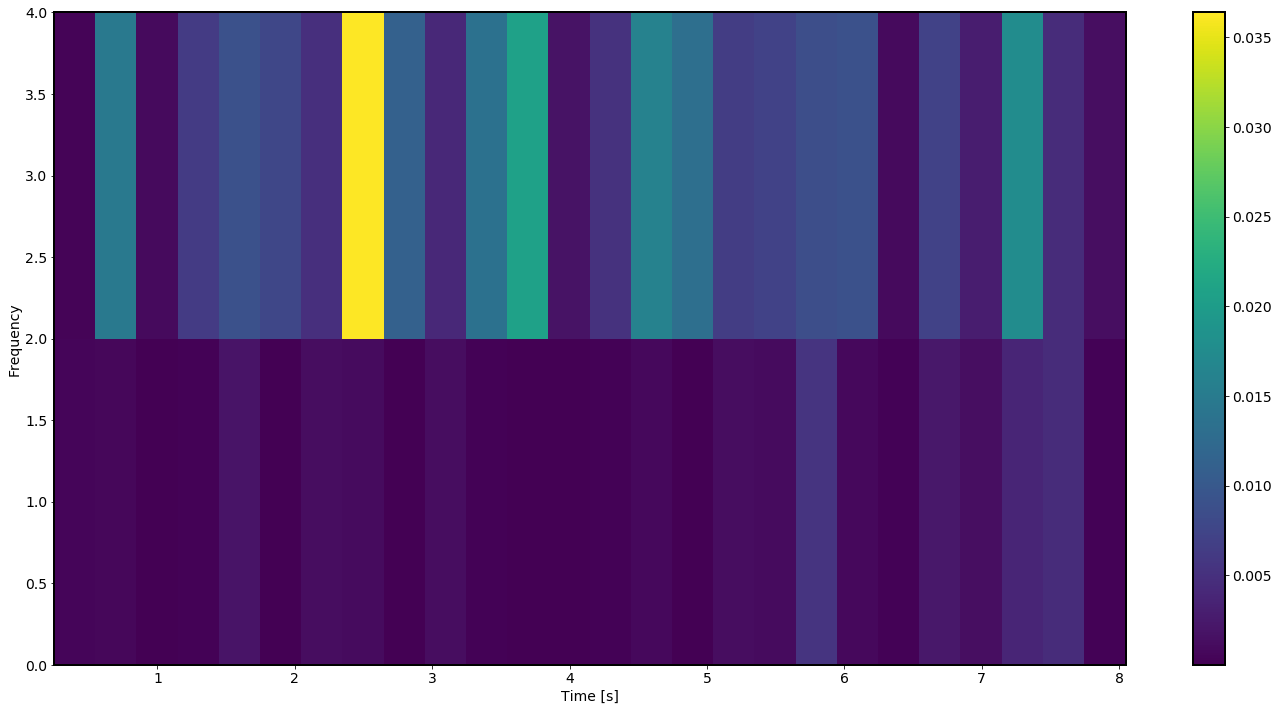

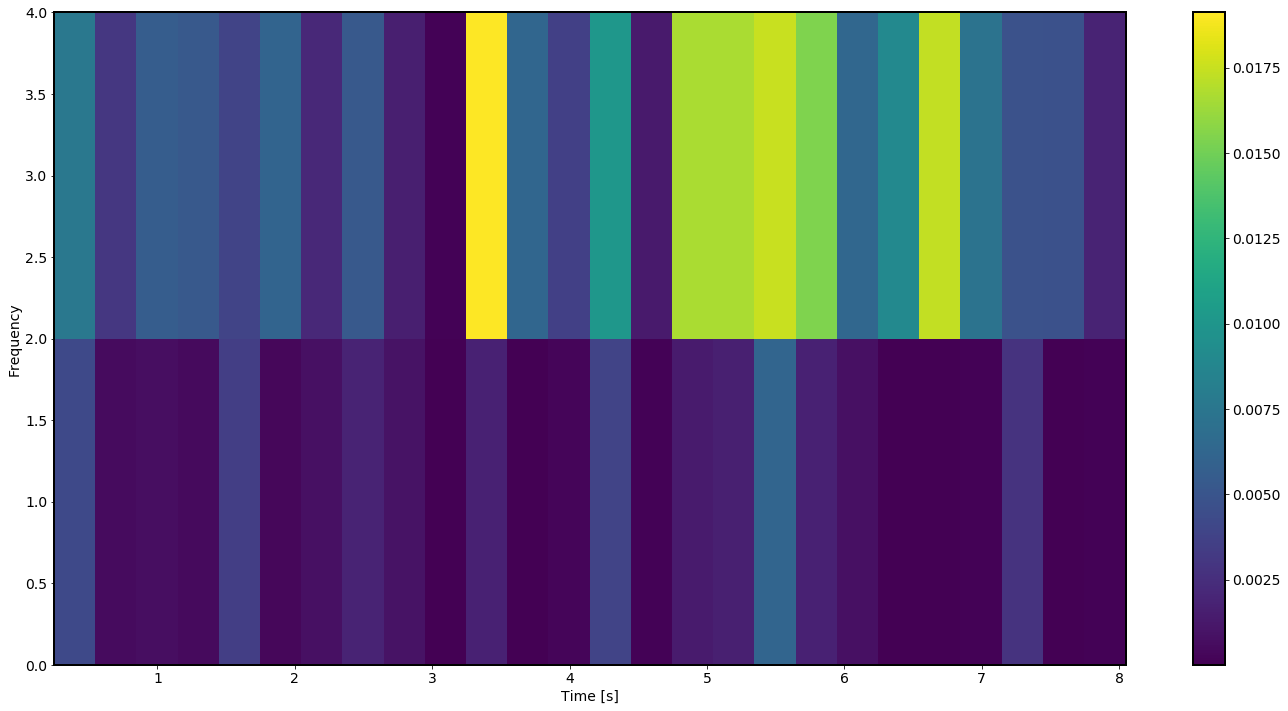

In [ ]:
plot_synced_time_slices(camera_positions, flight_num = 0, base_round_num = 0, distance = 10)

window_size = 5
noverlap = 2

time_slice_spectrogram(flight_num = 0, distance = 10, base_round_num = 0, spectro_round = 1,
                          spectro_window_size = window_size, spectro_noverlap = noverlap)

time_slice_spectrogram(flight_num = 0, distance = 10, base_round_num = 0, spectro_round = 2,
                          spectro_window_size = window_size, spectro_noverlap = noverlap)

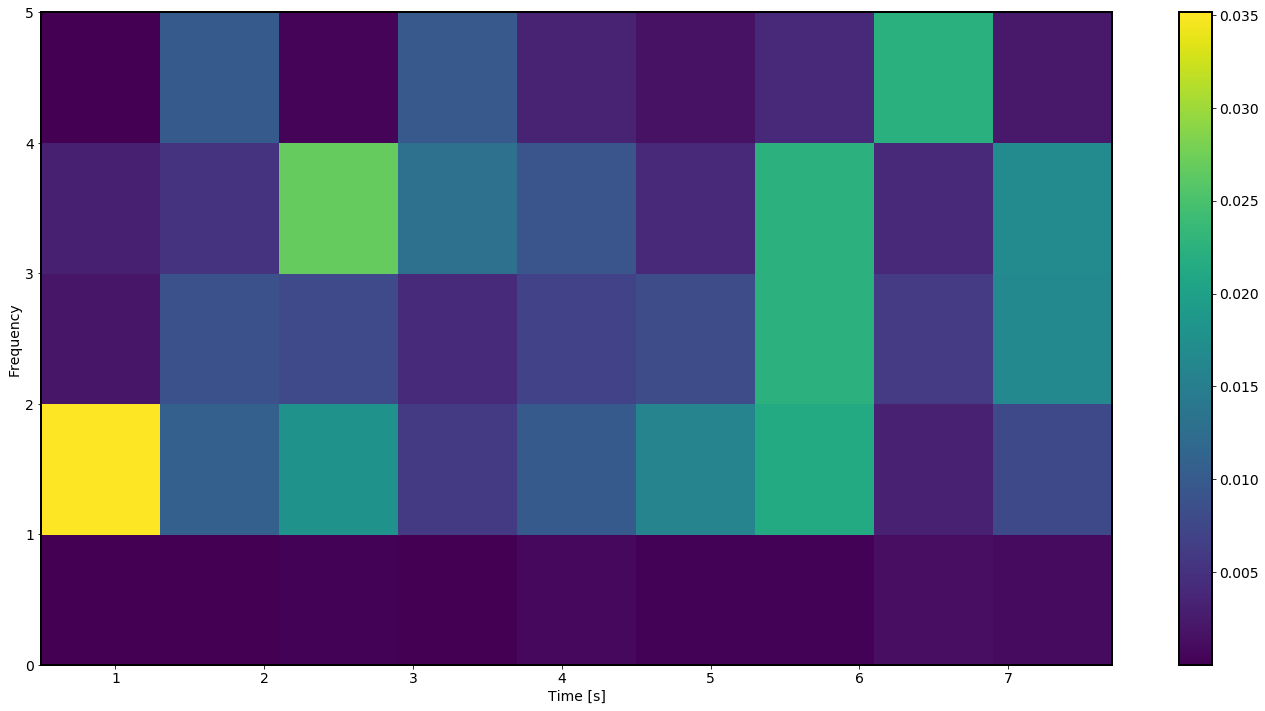

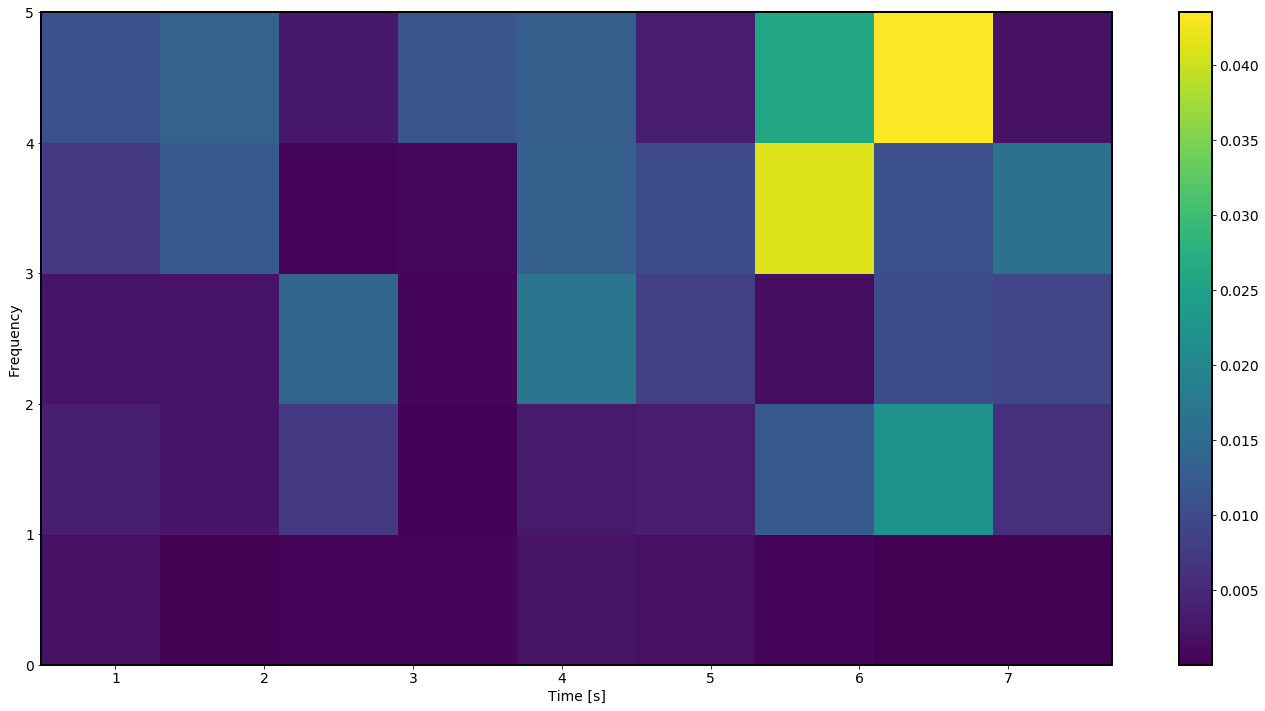

In [ ]:
window_size = 10
noverlap = 2

time_slice_spectrogram(flight_num = 0, distance = 10, base_round_num = 0, spectro_round = 1,
                          spectro_window_size = window_size, spectro_noverlap = noverlap)

time_slice_spectrogram(flight_num = 0, distance = 10, base_round_num = 0, spectro_round = 2,
                          spectro_window_size = window_size, spectro_noverlap = noverlap)

### Sliding Window Correlation

In [ ]:
def spectrogram_swc(distance, flight_num, base_round_num, spectro_window_size, spectro_noverlap=0, smoothness=0):
    points = get_points(camera_positions, flight_num)
    start_frames, end_frames = get_round_start_end(camera_positions, flight_num)
    ordered_points, mean_points, ordered_neuro = create_mean_parts(distance, points, spike_rates, flight_num)
    
    plt.figure(figsize = (12,6))
    
    round_len = 0
    
    base_round_points, base_round_mean, base_round_neuro = get_base_round(base_round_num, start_frames,
                                                                          end_frames, ordered_points, mean_points,
                                                                          ordered_neuro)
        
    matched_round_points, matched_round_neuro_data = match_rounds(flight_num, start_frames, end_frames, points,
                                                                  base_round_mean, spike_rates)
            
    matched_round_neuro_data = mean_bins(matched_round_neuro_data)
    base_round_neuro = mean_bins([base_round_neuro])[0]
        
    # offset = len(base_round_neuro) would lead to first correlation value nan
    offset = len(base_round_neuro) - 1
        
    rounds = [0 for i in range(offset)]
    for i in range(len(matched_round_neuro_data)):
        rounds.extend(matched_round_neuro_data[i])

    rounds.extend([0 for i in range(offset)])
        
    start = offset + (base_round_num * len(base_round_neuro))        
    corrs = Correlation.swc(rounds, start, start + len(base_round_neuro)).numpy()
        
    if smoothness > 0:
        corrs = np.nan_to_num(corrs)        
        x, y = smooth(corrs, len(corrs), smoothness)
            
        plt.plot(x, y, label = "Round {}".format(base_round_num + 1))
    else:
        plt.plot(corrs, label = "Round {}".format(base_round_num + 1))
            
    if round_len == 0:
        round_len = len(base_round_neuro) - 1
        
    plt.legend(loc='upper right')
    
    plt.axvspan(0, round_len, color='red', alpha=0.2)
    
    for round_num in range(len(start_frames) - 1):
        plt.axvspan(round_len + round_num * round_len, round_len + (round_num + 1) * round_len, color='green',
                    alpha=0.2)
    
    plt.axvspan(len(start_frames) * round_len, round_len + len(start_frames) * round_len, color='red', alpha=0.2)
    plt.show()
    
    plot_spectrogram(corrs, window_size = spectro_window_size, rate = 10, noverlap = spectro_noverlap,
                     use_log = True)

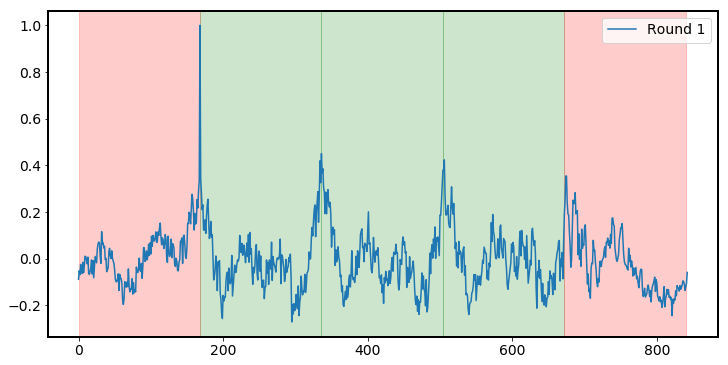

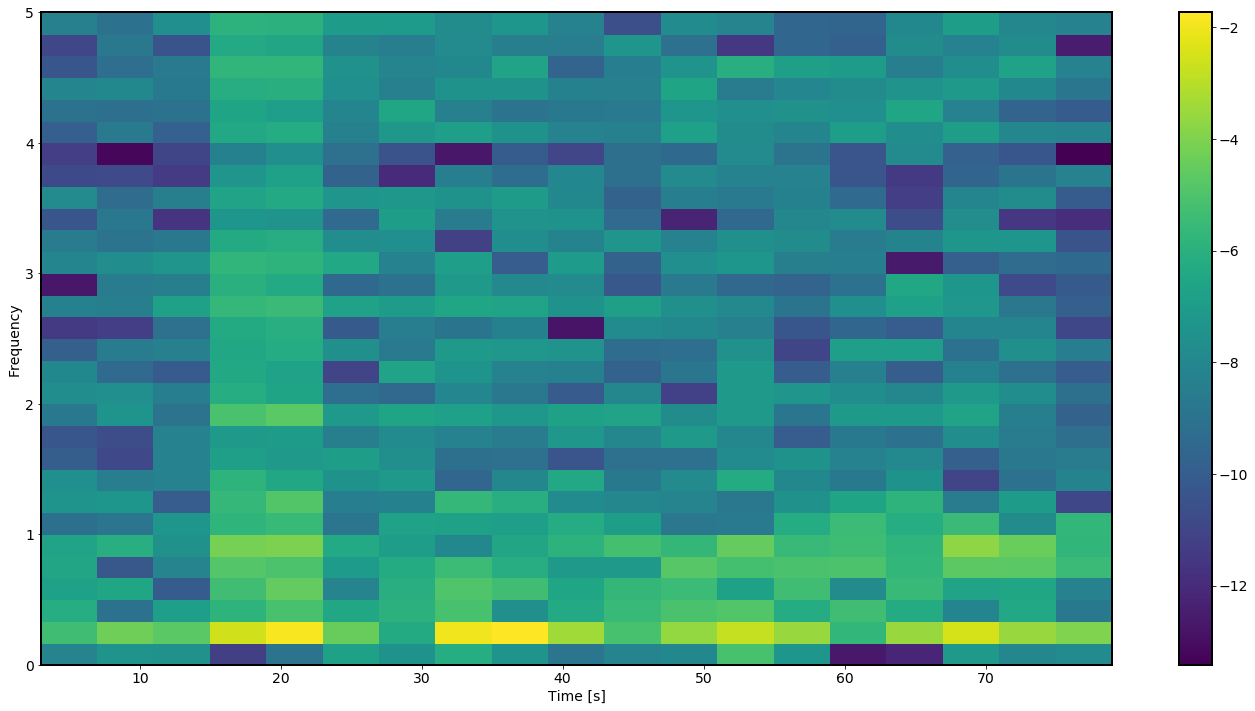

In [ ]:
spectrogram_swc(distance = 5, flight_num = 1, base_round_num = 0, spectro_window_size = 60, spectro_noverlap = 20)

## Voltage

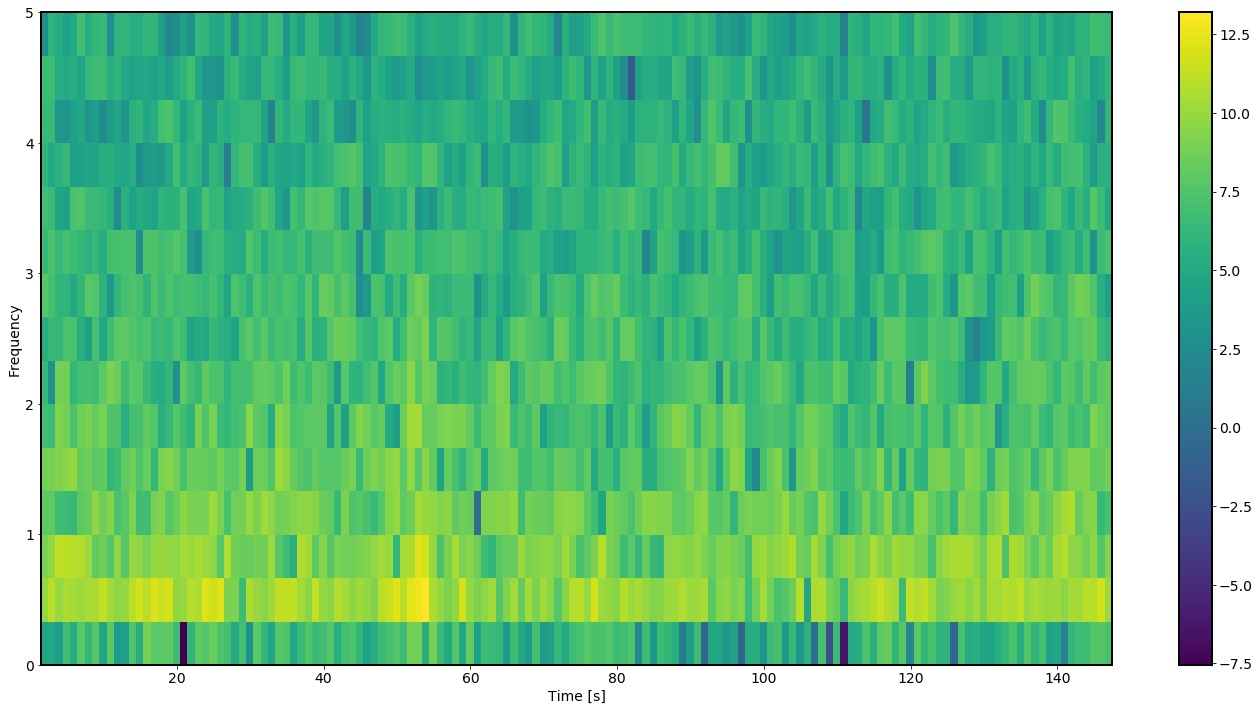

In [ ]:
plot_spectrogram(voltage_left[start_rounds[0][0] : end_rounds[0][0]],
                 window_size = 30,
                 rate = 10,
                 noverlap = 20,
                use_log = True)

# Fast Fourier Transform

## Spike Rate

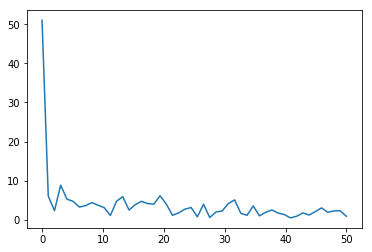

In [ ]:
y = spike_rates_small[0][start_rounds[0][1] * 10 : end_rounds[0][1] * 10]

# Number of samplepoints
N = 100 #len(y)

# sample spacing
T = 1.0 / 100.0
x = np.linspace(0.0, N*T, N)

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, (2.0/N * np.abs(yf[:N//2])))
plt.show()

In [ ]:
def get_length_corrected_swc(distance, flight_num, base_round_num, spectro_window_size, spectro_noverlap = 0,
                             smoothness = 0):
    
    points = get_points(camera_positions, flight_num)
    start_frames, end_frames = get_round_start_end(camera_positions, flight_num)
    ordered_points, mean_points, ordered_neuro = create_mean_parts(distance, points, spike_rates, flight_num)
    
    round_len = 0
    
    base_round_points, base_round_mean, base_round_neuro = get_base_round(base_round_num, start_frames, end_frames,
                                                                          ordered_points, mean_points,
                                                                          ordered_neuro)
        
    matched_round_points, matched_round_neuro_data = match_rounds(flight_num, start_frames, end_frames, points,
                                                                  base_round_mean, spike_rates)
            
    matched_round_neuro_data = mean_bins(matched_round_neuro_data)
    base_round_neuro = mean_bins([base_round_neuro])[0]
        
    # offset = len(base_round_neuro) would lead to first correlation value nan
    offset = len(base_round_neuro) - 1
        
    rounds = [0 for i in range(offset)]
    for i in range(len(matched_round_neuro_data)):
        rounds.extend(matched_round_neuro_data[i])

    rounds.extend([0 for i in range(offset)])
        
    start = offset + (base_round_num * len(base_round_neuro))        
    corrs = Correlation.swc(rounds, start, start + len(base_round_neuro)).numpy()
        
    if smoothness > 0:
        corrs = np.nan_to_num(corrs)        
        x, y = smooth(corrs, len(corrs), smoothness)
            
        return x, y
    else:
        return corrs
     
def plot_inverse_stft(signal_data, window_size, sample_rate, filter_threshold):
    f, t, Zxx = signal.stft(signal_data, fs=sample_rate, nperseg=window_size)
    plt.figure()
    plt.pcolormesh(t, f, np.abs(Zxx))
    plt.ylim([f[1], f[-1]])
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    #plt.yscale('log')
    plt.colorbar()
    plt.show()

    Zxx = np.where(np.abs(Zxx) >= filter_threshold, Zxx, 0)

    plt.figure()
    plt.pcolormesh(t, f, np.abs(Zxx))
    plt.ylim([f[1], f[-1]])
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    #plt.yscale('log')
    plt.colorbar()
    plt.show()

    _, xrec = signal.istft(Zxx, fs=sample_rate)

    time = np.arange(len(signal_data))

    plt.figure(figsize=(12, 5))
    plt.plot(time, signal_data, time, xrec[:len(signal_data)])
    plt.xlabel('Time [sec]')
    plt.ylabel('Pearson')
    plt.legend(['Original sliding window correlation', 'Filtered sliding window correlation via STFT'])
    plt.show()

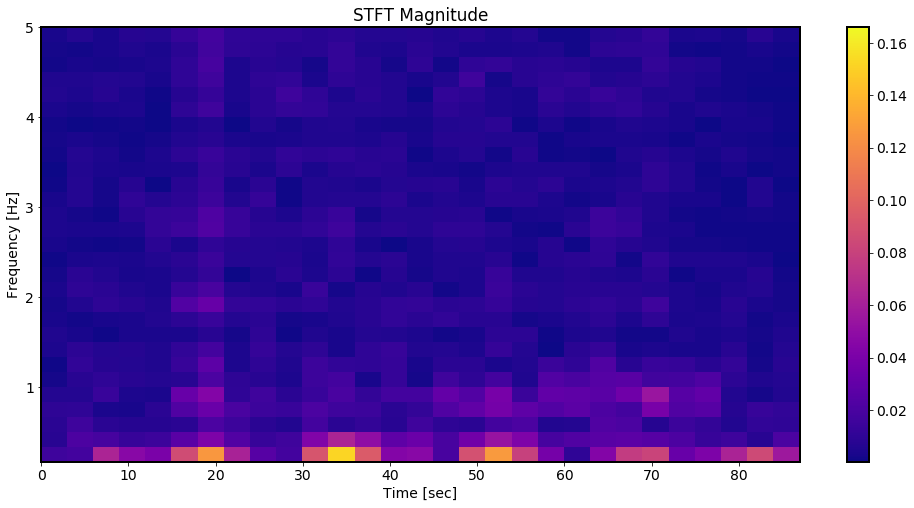

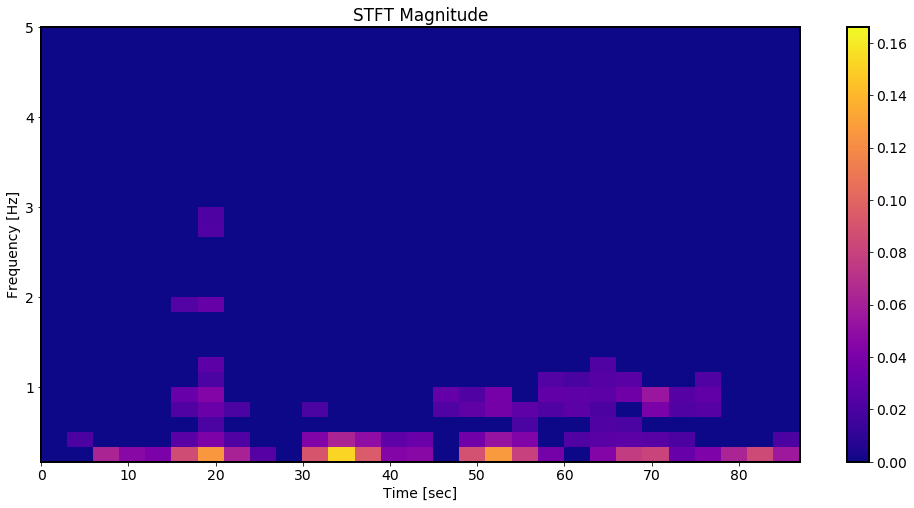

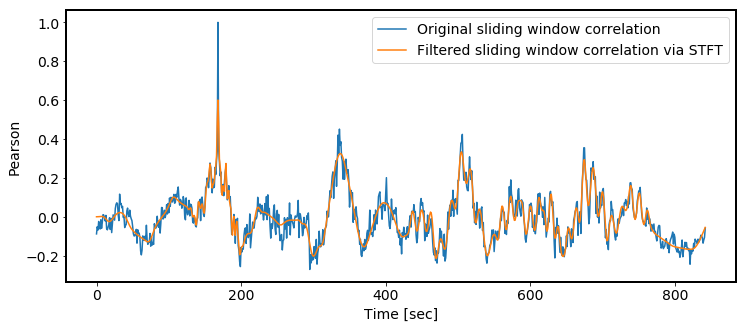

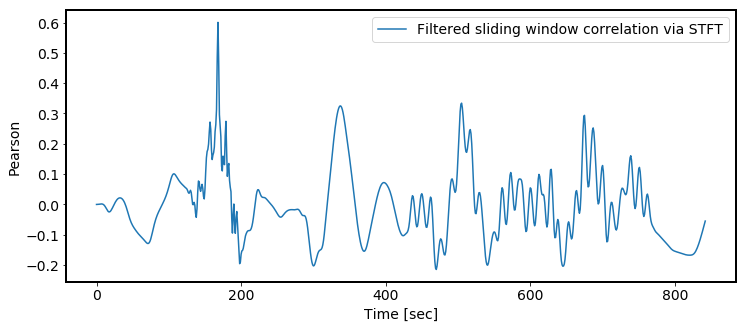

In [ ]:
swc = get_length_corrected_swc(distance = 5, flight_num = 1, base_round_num = 0,
                               spectro_window_size = 60, spectro_noverlap = 20)  

plot_inverse_stft(swc, window_size = 60, sample_rate = 10, filter_threshold = 0.02)

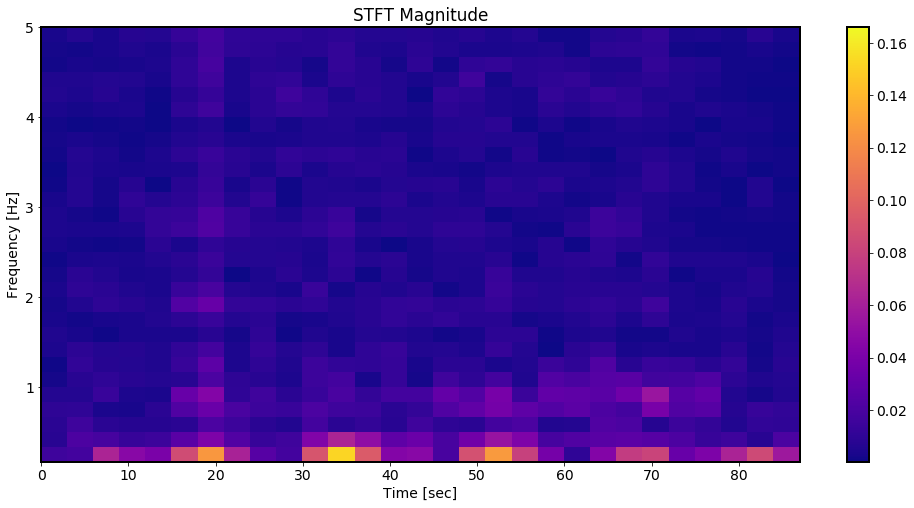

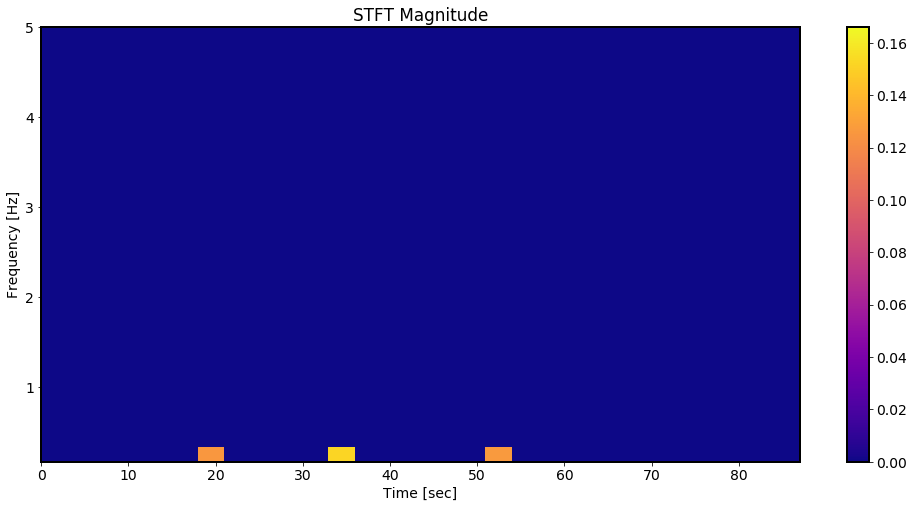

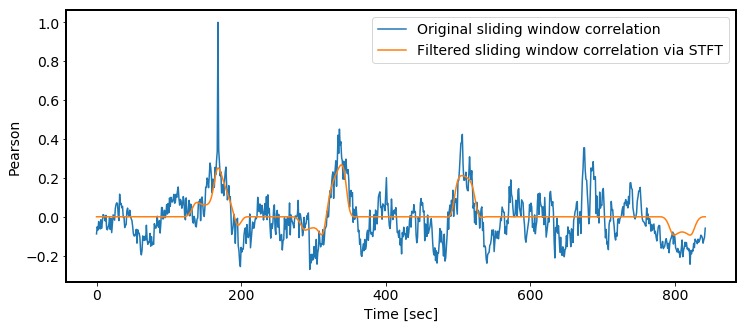

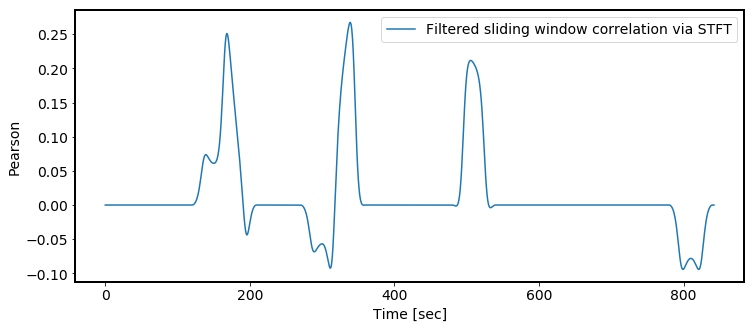

In [ ]:
plot_inverse_stft(swc, window_size = 60, sample_rate = 10, filter_threshold = 0.1)

## Voltage

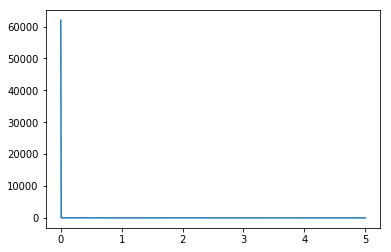

In [ ]:
y = voltage_left[start_rounds[0][0] : end_rounds[0][0]]

# Number of samplepoints
N = len(y)

# sample spacing
T = 1.0 / 10.0
x = np.linspace(0.0, N*T, N)

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, (2.0/N * np.abs(yf[:N//2])))
plt.show()

# Singular Spectrum Analysis

__SSA class is from: https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition__

In [ ]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (17,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [ ]:
def plot_ssa(data, window_length, plot_orig = False):
    F_ssa = SSA(data, window_length)
    F_ssa.components_to_df().plot()
    
    if plot_orig:
        F_ssa.orig_TS.plot(alpha=0.4)
        
    plt.xlabel("$t$")
    plt.ylabel(r"$\tilde{F}_i(t)$")
    plt.title(r"Singular Spectrum Analysis (window size = {})".format(window_length))
    
def plot_w_correlation(data, window_length):
    F_ssa = SSA(data, window_length)
    F_ssa.plot_wcorr()
    plt.title("W-Correlation (window size = {})".format(window_length))
    
    return F_ssa

def plot_spectrogram(data, window_size, rate, noverlap = 0, use_log = False):
    freqs, times, Sx = signal.spectrogram(data, fs = rate, nperseg = window_size, noverlap = noverlap)
    
    if use_log:
        Sx = np.log(Sx)

    f, ax = plt.subplots(figsize=(4.8 * 5, 2.4 * 5))
    mesh = ax.pcolormesh(times, freqs, Sx, cmap='viridis')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time [s]')
    plt.colorbar(mesh)

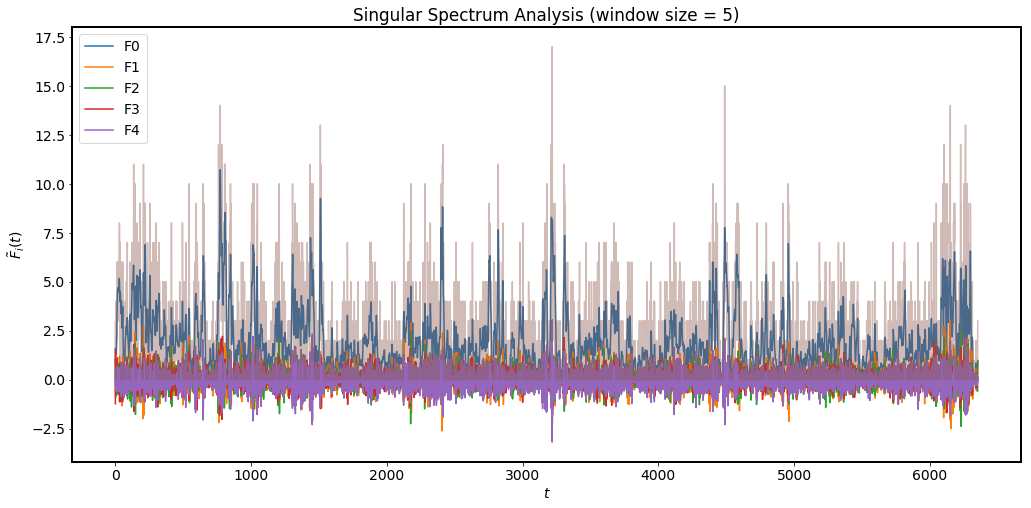

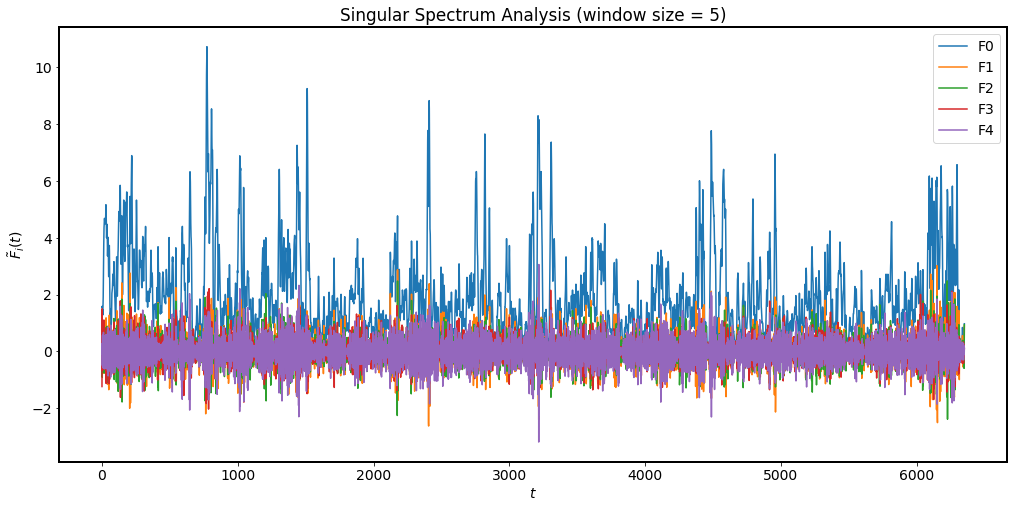

In [ ]:
plot_ssa(spike_rates[0], 5, True)
plot_ssa(spike_rates[0], 5)

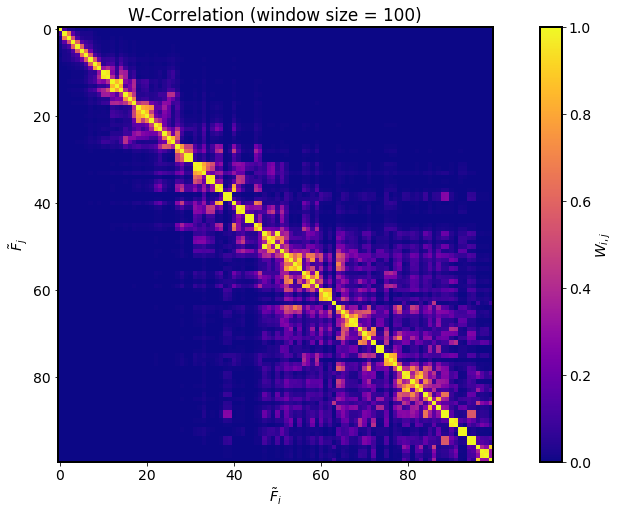

In [ ]:
F_ssa = plot_w_correlation(spike_rates[0], 100)

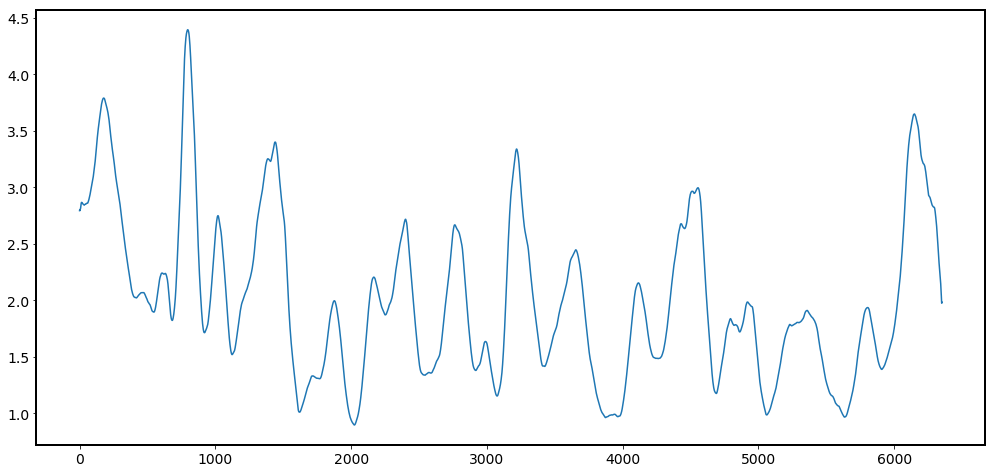

In [ ]:
F_ssa.reconstruct(0).plot()

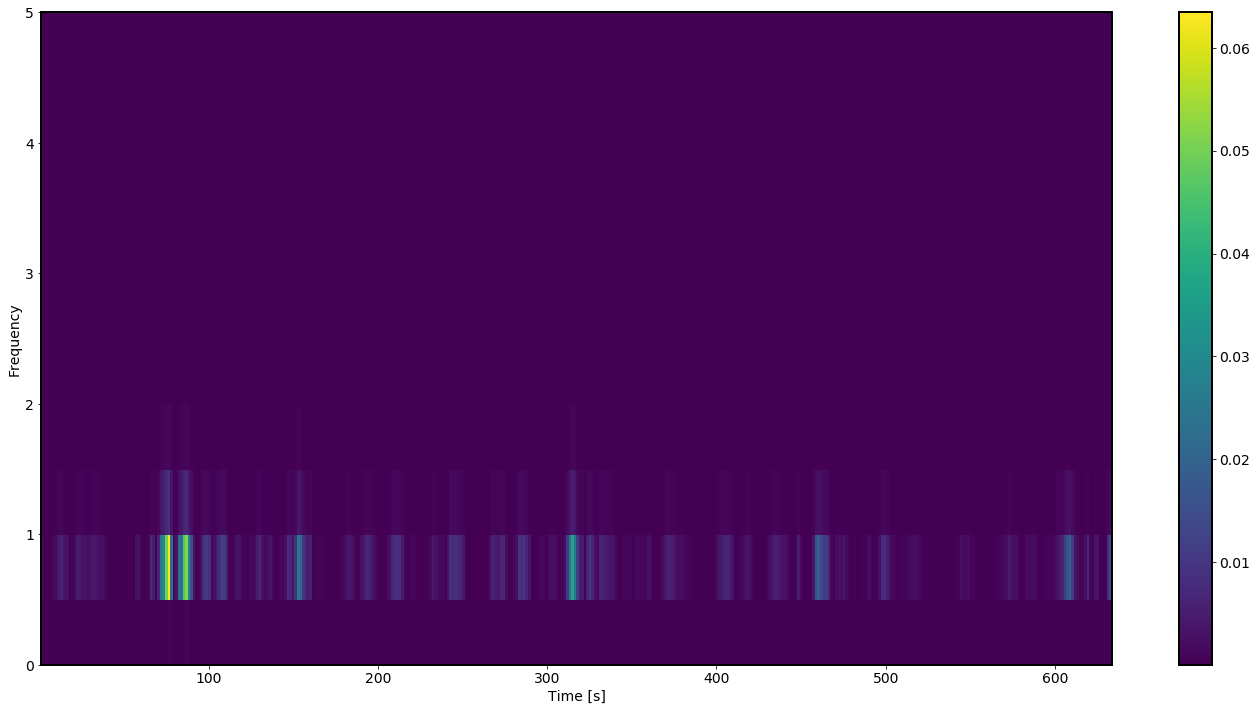

In [ ]:
flight_01 = F_ssa.reconstruct(0)

plot_spectrogram(flight_01, window_size = 20, rate = 10, noverlap = 5, use_log = False)

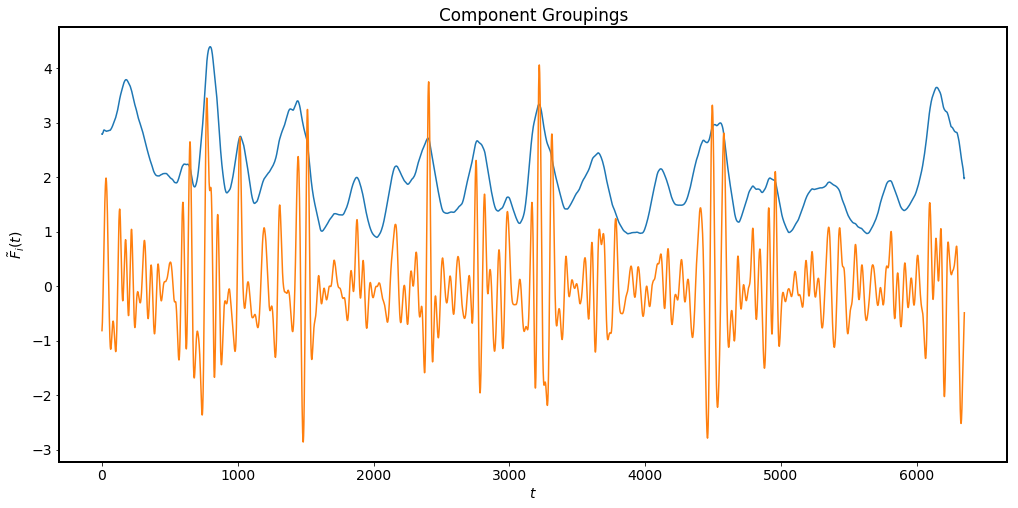

In [ ]:
F_ssa.reconstruct(0).plot()
F_ssa.reconstruct([1,2,3,4]).plot()

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings");

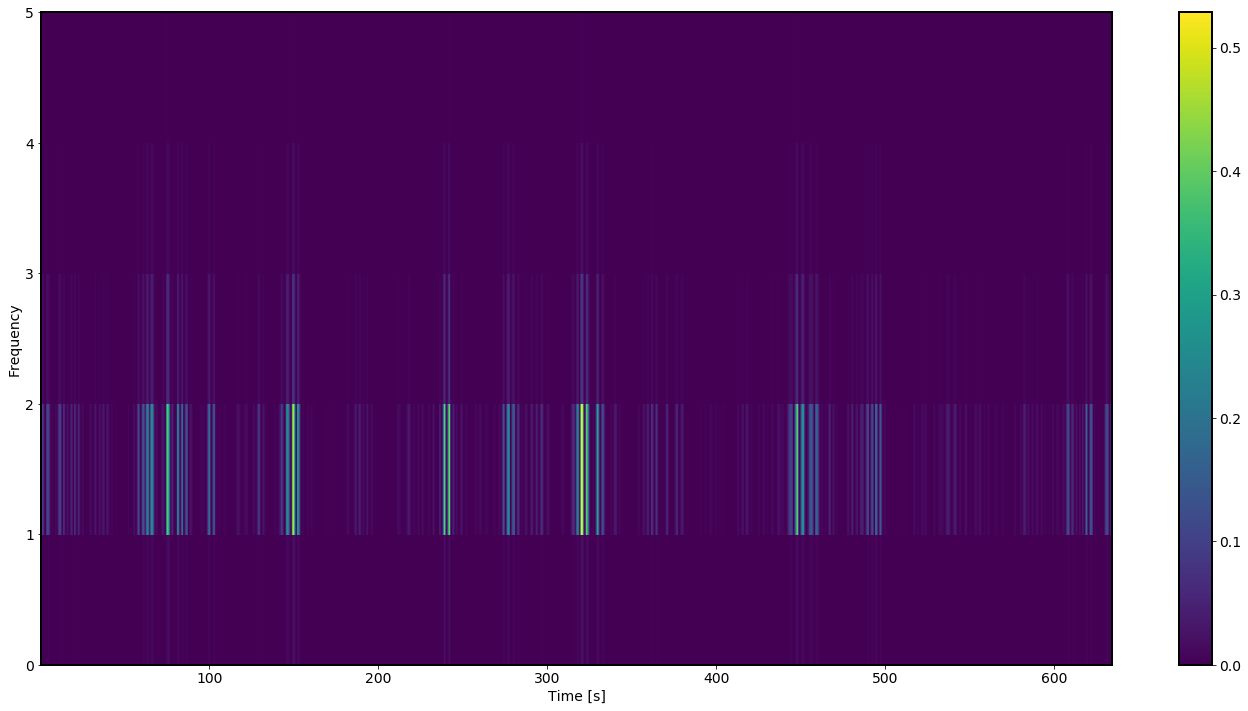

In [ ]:
flight_01 = F_ssa.reconstruct([1,2,3,4]).values

plot_spectrogram(flight_01, window_size = 10, rate = 10, noverlap = 5, use_log = False)

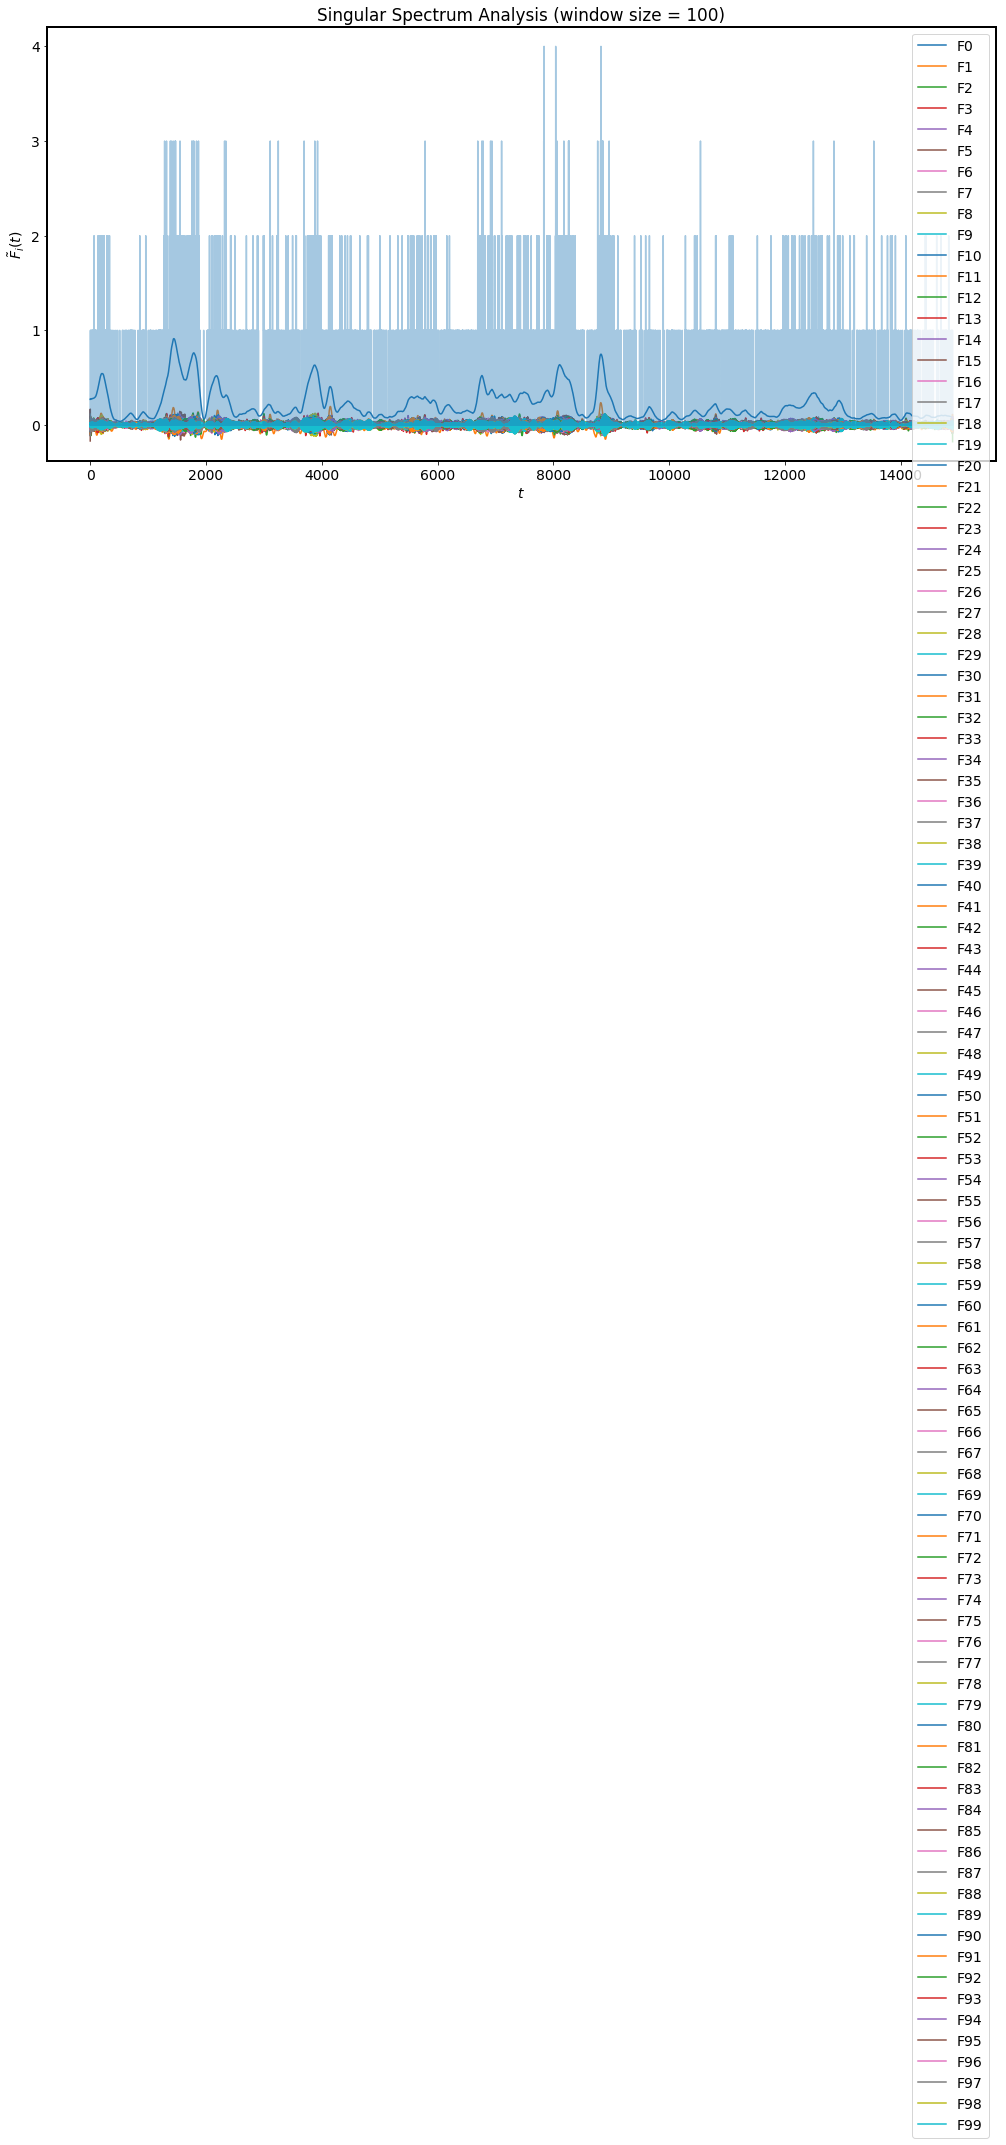

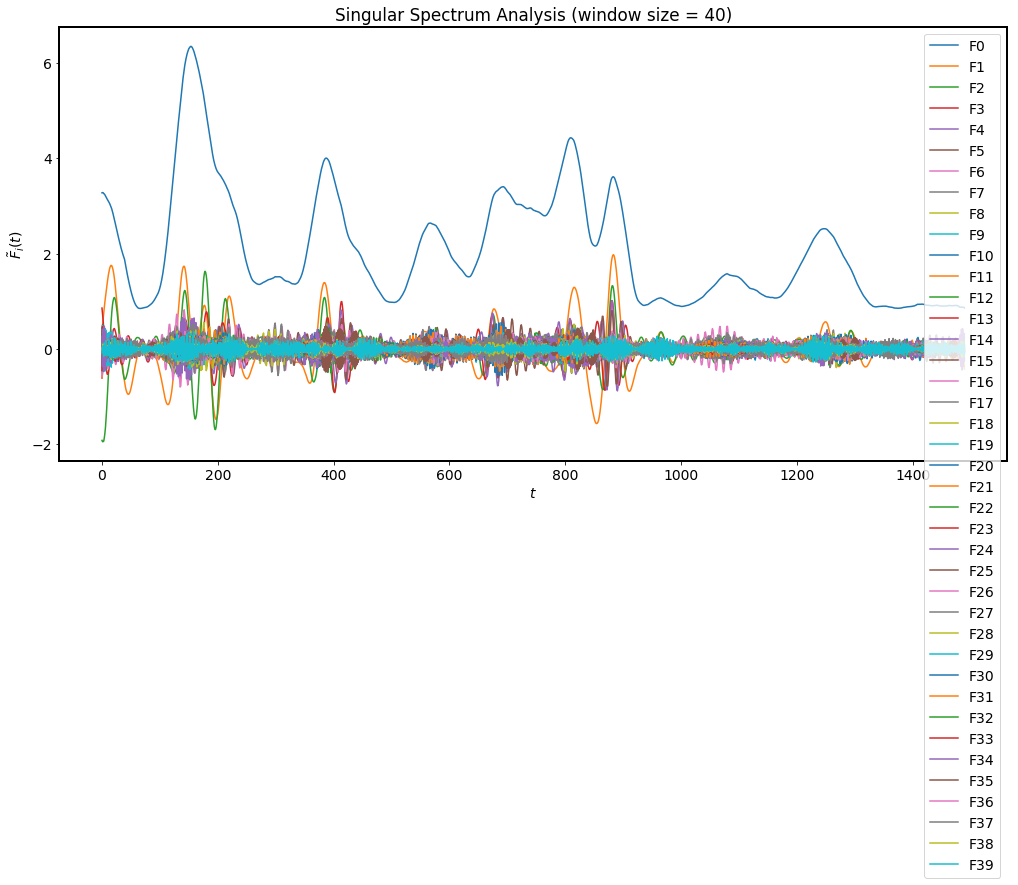

In [ ]:
plot_ssa(spike_rates_small[0][start_rounds[0][0] * 10 : end_rounds[0][0] * 10], 100, True)
plot_ssa(spike_rates[0][start_rounds[0][0] : end_rounds[0][0]], 40)